# Training a better model

In [1]:
sample_or_prod = True #True = sample, False = production

HOMEPATH = "/home/ubuntu/fastai/"
print("HOMEPATH:", HOMEPATH)
DATA_PATH = HOMEPATH + "data/dogscats/"




('HOMEPATH:', '/home/ubuntu/fastai/')


In [2]:
MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"

if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)

('WORKING_DATA:', '/home/ubuntu/fastai/data/dogscats/sample/')
('WORKING_TEST:', '/home/ubuntu/fastai/data/dogscats/sample/test/')
('WORKING_TRAIN:', '/home/ubuntu/fastai/data/dogscats/sample/train/')
('WORKING_VALID:', '/home/ubuntu/fastai/data/dogscats/sample/valid/')
('s_or_p:', '_sample_')


In [3]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [4]:
import os
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())

%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

('os.getcwd:', '/home/ubuntu/fastai')


Using Theano backend.


In [5]:
#path = "data/dogscats/sample/"
path = WORKING_DATA
model_path = MODEL_PATH
#if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64

In [6]:
def plot_history(histories):
    #histories : list of history objects. nb: history.history dictionary structure
    print ("len(histories):", len(histories))
    if len(histories)==1: 
        history = histories
        #needs fix
    else:
        #create empty history to copy into
        history = {}
        for i in histories[0].history.keys():
            history[i] = []
        #now combine all history[key] lists into one history[key] list.
        for hist in histories:
            for key in history.keys():
                history[key] += hist.history[key]
                #print (key, len(hist.history[key]), len(history[key]))

    # list all data in history
    print(history.keys(), len(history[history.keys()[0]]))
    for key in history.keys():
        print (key, ":", history[key][-1])

    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

## Are we underfitting?

Our validation accuracy so far has generally been higher than our training accuracy. That leads to two obvious questions:

1. How is this possible?
2. Is this desirable?

The answer to (1) is that this is happening because of *dropout*. Dropout refers to a layer that randomly deletes (i.e. sets to zero) each activation in the previous layer with probability *p* (generally 0.5). This only happens during training, not when calculating the accuracy on the validation set, which is why the validation set can show higher accuracy than the training set.

The purpose of dropout is to avoid overfitting. By deleting parts of the neural network at random during training, it ensures that no one part of the network can overfit to one part of the training set. The creation of dropout was one of the key developments in deep learning, and has allowed us to create rich models without overfitting. However, it can also result in underfitting if overused, and this is something we should be careful of with our model.

So the answer to (2) is: this is probably not desirable. It is likely that we can get better validation set results with less (or no) dropout, if we're seeing that validation accuracy is higher than training accuracy - a strong sign of underfitting. So let's try removing dropout entirely, and see what happens!

(We had dropout in this model already because the VGG authors found it necessary for the imagenet competition. But that doesn't mean it's necessary for dogs v cats, so we will do our own analysis of regularization approaches from scratch.)

## Removing dropout

Our high level approach here will be to start with our fine-tuned cats vs dogs model (with dropout), then fine-tune all the dense layers, after removing dropout from them. The steps we will take are:
- Re-create and load our modified VGG model with binary dependent (i.e. dogs v cats)
- Split the model between the convolutional (*conv*) layers and the dense layers
- Pre-calculate the output of the conv layers, so that we don't have to redundently re-calculate them on every epoch
- Create a new model with just the dense layers, and dropout p set to zero
- Train this new model using the output of the conv layers as training data.

As before we need to start with a working model, so let's bring in our working VGG 16 model and change it to predict our binary dependent...

In [7]:
model = vgg_ft(2)

...and load our fine-tuned weights.

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [9]:
model.load_weights(model_path+'finetune3.h5')

We're going to be training a number of iterations without dropout, so it would be best for us to pre-calculate the input to the fully connected layers - i.e. the *Flatten()* layer. We'll start by finding this layer in our model, and creating a new model that contains just the layers up to and including this layer:

In [10]:
layers = model.layers

In [11]:
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

In [12]:
last_conv_idx

30

In [13]:
layers[last_conv_idx]

In [14]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]

Now we can use the exact same approach to creating features as we used when we created the linear model from the imagenet predictions in the last lesson - it's only the model that has changed. As you're seeing, there's a fairly small number of "recipes" that can get us a long way!

In [15]:
batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
test_batches = get_batches(WORKING_TEST, shuffle=False, batch_size=batch_size)

trn_classes = batches.classes
val_classes = val_batches.classes
test_classes = test_batches.classes

trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)
test_labels = onehot(test_classes)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [16]:
print ("trn_classes:", type(trn_classes), trn_classes.shape)
print ("val_classes:", type(val_classes), val_classes.shape)
print ("test_classes:", type(test_classes), test_classes.shape)
print ("trn_labels:", type(trn_labels), trn_labels.shape)
print ("val_labels:", type(val_labels), val_labels.shape)

print ("test_labels:", type(test_labels), test_labels.shape)
#nb: test_labels are one column only 'unknown'

trn_classes: <type 'numpy.ndarray'> (2000,)
val_classes: <type 'numpy.ndarray'> (2000,)
test_classes: <type 'numpy.ndarray'> (12500,)
trn_labels: <type 'numpy.ndarray'> (2000, 2)
val_labels: <type 'numpy.ndarray'> (2000, 2)
test_labels: <type 'numpy.ndarray'> (12500, 1)


In [17]:
print ("batches.class_indices:", batches.class_indices)
print ("val_batches.class_indices:", val_batches.class_indices)
print ("test_batches.class_indices:", test_batches.class_indices)

batches.class_indices: {'cats': 0, 'dogs': 1}
val_batches.class_indices: {'cats': 0, 'dogs': 1}
test_batches.class_indices: {'unknown': 0}


In [18]:
test_features = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [19]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [20]:
print ("val_batches:", type(val_batches))
print ("val_batches.nb_sample:", type(val_batches.nb_sample), val_batches.nb_sample)

val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
val_batches.nb_sample: <type 'int'> 2000


In [21]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [22]:
print ("val_features:", type(val_features), val_features.shape)
print ("trn_features:", type(trn_features), trn_features.shape)
print ("test_features:", type(test_features), test_features.shape)


val_features: <type 'numpy.ndarray'> (2000, 512, 14, 14)
trn_features: <type 'numpy.ndarray'> (2000, 512, 14, 14)
test_features: <type 'numpy.ndarray'> (12500, 512, 14, 14)


In [23]:
#save_array(model_path + 'train_convlayer_features.bc', trn_features)
#save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [24]:
#trn_features = load_array(model_path+'train_convlayer_features.bc')
#val_features = load_array(model_path+'valid_convlayer_features.bc')

For our new fully connected model, we'll create it using the exact same architecture as the last layers of VGG 16, so that we can conveniently copy pre-trained weights over from that model. However, we'll set the dropout layer's p values to zero, so as to effectively remove dropout.

In [25]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [26]:
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [27]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
fc_model = get_fc_model()

And fit the model in the usual way:

In [30]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 2000 samples
Epoch 1/8
2000/2000 [==============================] - 3s - loss: 0.2632 - acc: 0.9805 - val_loss: 0.3533 - val_acc: 0.9745
Epoch 2/8
2000/2000 [==============================] - 3s - loss: 0.2031 - acc: 0.9860 - val_loss: 0.3159 - val_acc: 0.9775
Epoch 3/8
2000/2000 [==============================] - 3s - loss: 0.1892 - acc: 0.9865 - val_loss: 0.3076 - val_acc: 0.9785
Epoch 4/8
2000/2000 [==============================] - 3s - loss: 0.2027 - acc: 0.9865 - val_loss: 0.2856 - val_acc: 0.9805
Epoch 5/8
2000/2000 [==============================] - 3s - loss: 0.1280 - acc: 0.9910 - val_loss: 0.2972 - val_acc: 0.9795
Epoch 6/8
2000/2000 [==============================] - 3s - loss: 0.1140 - acc: 0.9925 - val_loss: 0.3272 - val_acc: 0.9780
Epoch 7/8
2000/2000 [==============================] - 3s - loss: 0.1048 - acc: 0.9935 - val_loss: 0.3142 - val_acc: 0.9800
Epoch 8/8
2000/2000 [==============================] - 3s - loss: 0.1048 - acc: 0.99

In [29]:
print ("model_path:", model_path)

model_path: /home/ubuntu/fastai/data/dogscats/models/


In [31]:
fc_model.save_weights(model_path+'fc_model_no_dropout.h5')

In [ ]:
#fc_model.load_weights(model_path+'fc_model_no_dropout.h5')

In [ ]:
# Resnet

In [38]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())

import resnet50; reload(resnet50)
from resnet50 import Resnet50

os.getcwd: /home/ubuntu/fastai


In [39]:
rn0 = Resnet50(include_top=False).model
print (type(rn0))

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


<class 'keras.engine.training.Model'>


In [40]:
rn0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 3, 224, 224)   0           input_2[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 3, 230, 230)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 112, 112)  9472        zeropadding2d_15[0][0]           
___________________________________________________________________________________________

res3a_branch2b (Convolution2D)   (None, 128, 28, 28)   147584      activation_60[0][0]              
____________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizatio (None, 128, 28, 28)   512         res3a_branch2b[0][0]             
____________________________________________________________________________________________________
activation_61 (Activation)       (None, 128, 28, 28)   0           bn3a_branch2b[0][0]              
____________________________________________________________________________________________________
res3a_branch2c (Convolution2D)   (None, 512, 28, 28)   66048       activation_61[0][0]              
____________________________________________________________________________________________________
res3a_branch1 (Convolution2D)    (None, 512, 28, 28)   131584      activation_59[0][0]              
___________________________________________________________________________________________

res4a_branch2a (Convolution2D)   (None, 256, 14, 14)   131328      activation_71[0][0]              
____________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizatio (None, 256, 14, 14)   1024        res4a_branch2a[0][0]             
____________________________________________________________________________________________________
activation_72 (Activation)       (None, 256, 14, 14)   0           bn4a_branch2a[0][0]              
____________________________________________________________________________________________________
res4a_branch2b (Convolution2D)   (None, 256, 14, 14)   590080      activation_72[0][0]              
____________________________________________________________________________________________________
bn4a_branch2b (BatchNormalizatio (None, 256, 14, 14)   1024        res4a_branch2b[0][0]             
___________________________________________________________________________________________

bn4e_branch2a (BatchNormalizatio (None, 256, 14, 14)   1024        res4e_branch2a[0][0]             
____________________________________________________________________________________________________
activation_84 (Activation)       (None, 256, 14, 14)   0           bn4e_branch2a[0][0]              
____________________________________________________________________________________________________
res4e_branch2b (Convolution2D)   (None, 256, 14, 14)   590080      activation_84[0][0]              
____________________________________________________________________________________________________
bn4e_branch2b (BatchNormalizatio (None, 256, 14, 14)   1024        res4e_branch2b[0][0]             
____________________________________________________________________________________________________
activation_85 (Activation)       (None, 256, 14, 14)   0           bn4e_branch2b[0][0]              
___________________________________________________________________________________________

res5c_branch2a (Convolution2D)   (None, 512, 7, 7)     1049088     activation_95[0][0]              
____________________________________________________________________________________________________
bn5c_branch2a (BatchNormalizatio (None, 512, 7, 7)     2048        res5c_branch2a[0][0]             
____________________________________________________________________________________________________
activation_96 (Activation)       (None, 512, 7, 7)     0           bn5c_branch2a[0][0]              
____________________________________________________________________________________________________
res5c_branch2b (Convolution2D)   (None, 512, 7, 7)     2359808     activation_96[0][0]              
____________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizatio (None, 512, 7, 7)     2048        res5c_branch2b[0][0]             
___________________________________________________________________________________________

In [41]:
print (rn0.output_shape[0:])
print (rn0.output_shape[1:])

(None, 2048, 7, 7)
(2048, 7, 7)


In [42]:
print ("batch_size:", batch_size)
print ("path:", path)

batch_size: 64
path: /home/ubuntu/fastai/data/dogscats/sample/


In [43]:
#previously
#val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
#val_classes = val_batches.classes
#val_classes: <type 'numpy.ndarray'> (2000,)
#val_labels = onehot(val_classes)
#val_labels: <type 'numpy.ndarray'> (2000, 2)


#batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)
#trn_classes = batches.classes
#trn_classes: <type 'numpy.ndarray'> (2000,)
#trn_labels = onehot(trn_classes)
#trn_labels: <type 'numpy.ndarray'> (2000, 2)

#below we see we can obtain the above and more in one step using get_classes

In [47]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [48]:
print ("val_classes:", type(val_classes), val_classes.shape)
print ("trn_classes:", type(trn_classes), trn_classes.shape)
print ("val_labels:", type(val_labels), val_labels.shape)
print ("trn_labels:", type(trn_labels), trn_labels.shape)
print ("val_filenames:", type(val_filenames), len(val_filenames))
print ("filenames:", type(filenames), len(filenames))
print ("test_filenames:", type(test_filenames), len(test_filenames))

val_classes: <type 'numpy.ndarray'> (2000,)
trn_classes: <type 'numpy.ndarray'> (2000,)
val_labels: <type 'numpy.ndarray'> (2000, 2)
trn_labels: <type 'numpy.ndarray'> (2000, 2)
val_filenames: <type 'list'> 2000
filenames: <type 'list'> 2000
test_filenames: <type 'list'> 12500


In [50]:
batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)
#exact same as identical line above
#nb: get_classes(path) calls batches = get_batches(path+'train', shuffle=False, batch_size=1)
#so this returns a directoryIterator with the nominated batch_size


Found 2000 images belonging to 2 classes.


In [51]:
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
#exact same as identical line above

Found 2000 images belonging to 2 classes.


In [52]:
print ("batches:", type(batches))
print ("val_batches:", type(val_batches))

batches: <class 'keras.preprocessing.image.DirectoryIterator'>
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>


In [53]:
val_features = rn0.predict_generator(val_batches, val_batches.nb_sample)

In [54]:
trn_features = rn0.predict_generator(batches, batches.nb_sample)

In [55]:
test_features = rn0.predict_generator(test_batches, test_batches.nb_sample)

In [56]:
print ("val_features:", type(val_features), val_features.shape)
print ("trn_features:", type(trn_features), trn_features.shape)
print ("test_features:", type(test_features), test_features.shape)


val_features: <type 'numpy.ndarray'> (2000, 2048, 7, 7)
trn_features: <type 'numpy.ndarray'> (2000, 2048, 7, 7)
test_features: <type 'numpy.ndarray'> (12500, 2048, 7, 7)


In [57]:
def get_fc_layers(p):
    #first layer takes input from output of model rn0.
    #last layer provides two outputs for two categories.
    return [
        BatchNormalization(axis=1, input_shape=rn0.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [58]:
model = Sequential(get_fc_layers(0.5))

In [ ]:
model.summary()

In [59]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
print ("batch_size:", batch_size)

batch_size: 64


In [61]:
model.fit(trn_features, trn_labels, nb_epoch=2, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 2000 samples
Epoch 1/2
2000/2000 [==============================] - 4s - loss: 0.2117 - acc: 0.9485 - val_loss: 0.8098 - val_acc: 0.9385
Epoch 2/2
2000/2000 [==============================] - 4s - loss: 0.0699 - acc: 0.9880 - val_loss: 0.2282 - val_acc: 0.9730


In [62]:
def get_ap_layers(p):
    #first layer takes input from output of model rn0.
    #last layer provides two outputs for two categories.
    return [
        GlobalAveragePooling2D(input_shape=rn0.output_shape[1:]),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [63]:
model = Sequential(get_ap_layers(0.2))

In [ ]:
model.summary()

In [64]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 2000 samples
Epoch 1/3
2000/2000 [==============================] - 0s - loss: 0.2250 - acc: 0.9095 - val_loss: 0.0723 - val_acc: 0.9765
Epoch 2/3
2000/2000 [==============================] - 0s - loss: 0.0664 - acc: 0.9785 - val_loss: 0.0571 - val_acc: 0.9820
Epoch 3/3
2000/2000 [==============================] - 0s - loss: 0.0378 - acc: 0.9895 - val_loss: 0.0530 - val_acc: 0.9830


In [ ]:
#Resnet50 Large

In [66]:
rn0 = Resnet50(include_top=False, size=(400,400)).model
print (type(rn0))

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 400, 400)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


<class 'keras.engine.training.Model'>


In [67]:
rn0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 400, 400)   0                                            
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 3, 400, 400)   0           input_3[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_16 (ZeroPadding2D) (None, 3, 406, 406)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 200, 200)  9472        zeropadding2d_16[0][0]           
___________________________________________________________________________________________

res3a_branch2b (Convolution2D)   (None, 128, 50, 50)   147584      activation_109[0][0]             
____________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizatio (None, 128, 50, 50)   512         res3a_branch2b[0][0]             
____________________________________________________________________________________________________
activation_110 (Activation)      (None, 128, 50, 50)   0           bn3a_branch2b[0][0]              
____________________________________________________________________________________________________
res3a_branch2c (Convolution2D)   (None, 512, 50, 50)   66048       activation_110[0][0]             
____________________________________________________________________________________________________
res3a_branch1 (Convolution2D)    (None, 512, 50, 50)   131584      activation_108[0][0]             
___________________________________________________________________________________________

res4a_branch2a (Convolution2D)   (None, 256, 25, 25)   131328      activation_120[0][0]             
____________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizatio (None, 256, 25, 25)   1024        res4a_branch2a[0][0]             
____________________________________________________________________________________________________
activation_121 (Activation)      (None, 256, 25, 25)   0           bn4a_branch2a[0][0]              
____________________________________________________________________________________________________
res4a_branch2b (Convolution2D)   (None, 256, 25, 25)   590080      activation_121[0][0]             
____________________________________________________________________________________________________
bn4a_branch2b (BatchNormalizatio (None, 256, 25, 25)   1024        res4a_branch2b[0][0]             
___________________________________________________________________________________________

bn4e_branch2b (BatchNormalizatio (None, 256, 25, 25)   1024        res4e_branch2b[0][0]             
____________________________________________________________________________________________________
activation_134 (Activation)      (None, 256, 25, 25)   0           bn4e_branch2b[0][0]              
____________________________________________________________________________________________________
res4e_branch2c (Convolution2D)   (None, 1024, 25, 25)  263168      activation_134[0][0]             
____________________________________________________________________________________________________
bn4e_branch2c (BatchNormalizatio (None, 1024, 25, 25)  4096        res4e_branch2c[0][0]             
____________________________________________________________________________________________________
merge_44 (Merge)                 (None, 1024, 25, 25)  0           bn4e_branch2c[0][0]              
                                                                   activation_132[0][0]    

bn5c_branch2a (BatchNormalizatio (None, 512, 13, 13)   2048        res5c_branch2a[0][0]             
____________________________________________________________________________________________________
activation_145 (Activation)      (None, 512, 13, 13)   0           bn5c_branch2a[0][0]              
____________________________________________________________________________________________________
res5c_branch2b (Convolution2D)   (None, 512, 13, 13)   2359808     activation_145[0][0]             
____________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizatio (None, 512, 13, 13)   2048        res5c_branch2b[0][0]             
____________________________________________________________________________________________________
activation_146 (Activation)      (None, 512, 13, 13)   0           bn5c_branch2b[0][0]              
___________________________________________________________________________________________

In [68]:
print ("rn0.output_shape[]:", rn0.output_shape)
print ("rn0.output_shape[1:]:", rn0.output_shape[1:])

rn0.output_shape[]: (None, 2048, 13, 13)
rn0.output_shape[1:]: (2048, 13, 13)


In [69]:
batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size, target_size = (400,400))

Found 2000 images belonging to 2 classes.


In [70]:
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size*2, target_size = (400,400))

Found 2000 images belonging to 2 classes.


In [71]:
test_batches = get_batches(WORKING_TEST, shuffle=False, batch_size=batch_size*2, target_size = (400,400))

Found 12500 images belonging to 1 classes.


In [72]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [73]:
print ("val_classes:", type(val_classes), val_classes.shape)
print ("trn_classes:", type(trn_classes), trn_classes.shape)
print ("val_labels:", type(val_labels), val_labels.shape)
print ("trn_labels:", type(trn_labels), trn_labels.shape)
print ("val_filenames:", type(val_filenames), len(val_filenames))
print ("filenames:", type(filenames), len(filenames))
print ("test_filenames:", type(test_filenames), len(test_filenames))

val_classes: <type 'numpy.ndarray'> (2000,)
trn_classes: <type 'numpy.ndarray'> (2000,)
val_labels: <type 'numpy.ndarray'> (2000, 2)
trn_labels: <type 'numpy.ndarray'> (2000, 2)
val_filenames: <type 'list'> 2000
filenames: <type 'list'> 2000
test_filenames: <type 'list'> 12500


In [74]:
val_features = rn0.predict_generator(val_batches, val_batches.nb_sample)#same as previously assigned val_features.

In [75]:
print ("val_features:", type(val_features), val_features.shape)

val_features: <type 'numpy.ndarray'> (2000, 2048, 13, 13)


In [76]:
trn_features = rn0.predict_generator(batches, batches.nb_sample)#same as previously assigned val_features?

In [77]:
print ("trn_features:", type(trn_features), trn_features.shape)

trn_features: <type 'numpy.ndarray'> (2000, 2048, 13, 13)


In [79]:
test_features = rn0.predict_generator(test_batches, test_batches.nb_sample)#same as previously assigned val_features?

In [80]:
print ("test_features:", type(test_features), test_features.shape)

test_features: <type 'numpy.ndarray'> (12500, 2048, 13, 13)


In [81]:
model = Sequential(get_ap_layers(0.01))
#NB: get_ap_layers creates stack of layers with input parameters to suit output from model rn0.
#NBB: future todo: modify method to include input model as a parameter.

In [82]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
globalaveragepooling2d_2 (Global (None, 2048)          0           globalaveragepooling2d_input_2[0]
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 2048)          0           globalaveragepooling2d_2[0][0]   
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 2)             4098        dropout_9[0][0]                  
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
____________________________________________________________________________________________________


In [83]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
history1 = model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))
#NB: using sample data, loss: 0.0550 - acc: 0.9885 - val_loss: 0.0654 - val_acc: 0.9815
#NBB: video shows acc:0.9898 val_acc:0.9930 - it is using full dataset not sample. run again with to use full dataset.

Train on 2000 samples, validate on 2000 samples
Epoch 1/3
2000/2000 [==============================] - 3s - loss: 0.2641 - acc: 0.9015 - val_loss: 0.1068 - val_acc: 0.9685
Epoch 2/3
2000/2000 [==============================] - 3s - loss: 0.0751 - acc: 0.9815 - val_loss: 0.0751 - val_acc: 0.9765
Epoch 3/3
2000/2000 [==============================] - 3s - loss: 0.0501 - acc: 0.9905 - val_loss: 0.0659 - val_acc: 0.9805


In [85]:
history2 = model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))


Train on 2000 samples, validate on 2000 samples
Epoch 1/3
2000/2000 [==============================] - 3s - loss: 0.0392 - acc: 0.9925 - val_loss: 0.0598 - val_acc: 0.9805
Epoch 2/3
2000/2000 [==============================] - 3s - loss: 0.0315 - acc: 0.9940 - val_loss: 0.0534 - val_acc: 0.9810
Epoch 3/3
2000/2000 [==============================] - 3s - loss: 0.0268 - acc: 0.9955 - val_loss: 0.0511 - val_acc: 0.9820


In [86]:
history3 = model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))


Train on 2000 samples, validate on 2000 samples
Epoch 1/3
2000/2000 [==============================] - 3s - loss: 0.0226 - acc: 0.9965 - val_loss: 0.0485 - val_acc: 0.9825
Epoch 2/3
2000/2000 [==============================] - 3s - loss: 0.0221 - acc: 0.9965 - val_loss: 0.0481 - val_acc: 0.9835
Epoch 3/3
2000/2000 [==============================] - 3s - loss: 0.0178 - acc: 0.9965 - val_loss: 0.0458 - val_acc: 0.9845


len(histories): 3
['acc', 'loss', 'val_acc', 'val_loss'] 9
acc : 0.9965
loss : 0.01775527215
val_acc : 0.9845
val_loss : 0.045766580224


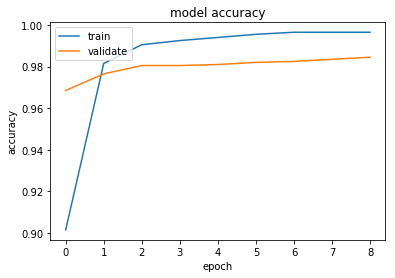

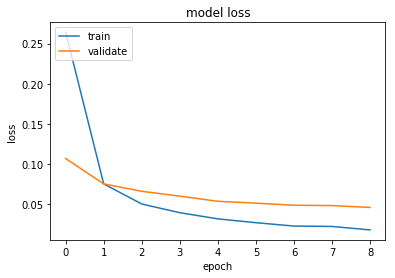

In [87]:
plot_history([history1, history2, history3])

In [88]:
model.save_weights(model_path + 'model_get_ap_layers_p01.h5')

In [ ]:
#test_features = model.predict_generator(test_batches, test_batches.nb_sample)

In [89]:
model.evaluate(trn_features, trn_labels, batch_size=batch_size)

1984/2000 [============================>.] - ETA: 0s

[0.01494270320236683, 0.99950000000000006]

In [90]:
preds = model.predict(test_features, batch_size=batch_size)

In [91]:
print ("preds:", type(preds), preds.shape)

preds: <type 'numpy.ndarray'> (12500, 2)


In [92]:
preds[0,]

array([ 0.9624,  0.0376], dtype=float32)

In [96]:
len(test_filenames), test_filenames[0:5]

(12500,
 ['unknown/2957.jpg',
  'unknown/11706.jpg',
  'unknown/10629.jpg',
  'unknown/9810.jpg',
  'unknown/9834.jpg'])

In [100]:
#assemble list of filenames, strip directory and extension. keep for generating submission file.
count = 0
filenames_int = []
for name in test_filenames:
    #print (name)
    #print (name.find("/"))
    name_int = int(name[7+1:len(name)-4])
    #print ("name_int:", name_int)
    filenames_int.append(name_int)
    count += 1
    #if count ==10: break
print ("filenames_int:", len(filenames_int))
print (filenames_int[0:20])
#convert list to numpy array - enables joining to form csv file
filenames_int = np.asarray(filenames_int)
print ("filenames_int:", filenames_int.shape)
print (filenames_int[0:20])

filenames_int: 12500
[2957, 11706, 10629, 9810, 9834, 5308, 2850, 6998, 6901, 7008, 10673, 9721, 1516, 12433, 8143, 12332, 9660, 1707, 6581, 4762]
filenames_int: (12500,)
[ 2957 11706 10629  9810  9834  5308  2850  6998  6901  7008 10673  9721  1516 12433  8143 12332
  9660  1707  6581  4762]


#extract of sample_submission.csv
id,label
1,0.5
2,0.5
3,0.5

where label = prob of being a dog (?)

In [94]:
preds_dogs = preds[:, 1]
print ("preds_dogs.shape:", preds_dogs.shape)
print (preds_dogs[0:20])

preds_dogs.shape: (12500,)
[  3.7594e-02   5.2407e-01   9.9984e-01   9.9418e-01   2.9335e-03   4.6005e-01   1.3474e-02
   9.9827e-01   9.9861e-01   9.9428e-01   9.2422e-05   9.9359e-01   9.7335e-01   9.9787e-01
   5.0218e-03   1.2404e-04   3.7811e-03   9.9226e-01   9.9899e-01   9.9973e-01]


In [95]:
preds_dogs = preds_dogs.clip(min=0.05, max=0.95)
print (preds_dogs[0:20])

[ 0.05    0.5241  0.95    0.95    0.05    0.4601  0.05    0.95    0.95    0.95    0.05    0.95    0.95
  0.95    0.05    0.05    0.05    0.95    0.95    0.95  ]


In [101]:
#reshape
print(filenames_int.shape)
filenames_int_ = filenames_int.reshape((filenames_int.shape[0], 1))
print(filenames_int_.shape)
#print(filenames_int_)

(12500,)
(12500, 1)


In [102]:
print(preds_dogs.shape)
preds_dogs_ = preds_dogs.reshape((preds_dogs.shape[0], 1))
print(preds_dogs_.shape)
#print(preds_dogs_)

(12500,)
(12500, 1)


In [103]:
result = np.hstack((filenames_int_, preds_dogs_))
print ("result:", result.shape)
print (result[0:10, :])

result: (12500, 2)
[[  2.9570e+03   5.0000e-02]
 [  1.1706e+04   5.2407e-01]
 [  1.0629e+04   9.5000e-01]
 [  9.8100e+03   9.5000e-01]
 [  9.8340e+03   5.0000e-02]
 [  5.3080e+03   4.6005e-01]
 [  2.8500e+03   5.0000e-02]
 [  6.9980e+03   9.5000e-01]
 [  6.9010e+03   9.5000e-01]
 [  7.0080e+03   9.5000e-01]]


In [108]:
result = result[result[:,0].argsort()]
result[0:5, ]

array([[ 1.  ,  0.05],
       [ 2.  ,  0.95],
       [ 3.  ,  0.95],
       [ 4.  ,  0.95],
       [ 5.  ,  0.05]])

In [109]:
RESULTS_PATH

'/home/ubuntu/fastai/data/dogscats/results/'

In [110]:
np.savetxt(RESULTS_PATH+'30-12-submit.csv', result, fmt = ("%1u", "%.2f"), delimiter=',', header="id,label", comments='')

# Reducing overfitting

Now that we've gotten the model to overfit, we can take a number of steps to reduce this.

## Approaches to reducing overfitting

We do not necessarily need to rely on dropout or other regularization approaches to reduce overfitting. There are other techniques we should try first, since regularlization, by definition, biases our model towards simplicity - which we only want to do if we know that's necessary. This is the order that we recommend using for reducing overfitting (more details about each in a moment):

1. Add more data
2. Use data augmentation
3. Use architectures that generalize well
4. Add regularization
5. Reduce architecture complexity.

We'll assume that you've already collected as much data as you can, so step (1) isn't relevant (this is true for most Kaggle competitions, for instance). So the next step (2) is data augmentation. This refers to creating additional synthetic data, based on reasonable modifications of your input data. For images, this is likely to involve one or more of: flipping, rotation, zooming, cropping, panning, minor color changes.

Which types of augmentation are appropriate depends on your data. For regular photos, for instance, you'll want to use horizontal flipping, but not vertical flipping (since an upside down car is much less common than a car the right way up, for instance!)

We recommend *always* using at least some light data augmentation, unless you have so much data that your model will never see the same input twice.

## About data augmentation

Keras comes with very convenient features for automating data augmentation. You simply define what types and maximum amounts of augmentation you want, and keras ensures that every item of every batch randomly is changed according to these settings. Here's how to define a generator that includes data augmentation:

In [ ]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

Let's take a look at how this generator changes a single image (the details of this code don't matter much, but feel free to read the comments and keras docs to understand the details if you're interested).

In [ ]:
# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread('data/dogscats/test/7.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [ ]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

In [ ]:
# The original
plt.imshow(img[0])

As you can see below, there's no magic to data augmentation - it's a very intuitive approach to generating richer input data. Generally speaking, your intuition should be a good guide to appropriate data augmentation, although it's a good idea to test your intuition by checking the results of different augmentation approaches.

In [ ]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [ ]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

## Adding data augmentation

Let's try adding a small amount of data augmentation, and see if we reduce overfitting as a result. The approach will be identical to the method we used to finetune the dense layers in lesson 2, except that we will use a generator with augmentation configured. Here's how we set up the generator, and create batches from it:

In [ ]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [ ]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

When using data augmentation, we can't pre-compute our convolutional layer features, since randomized changes are being made to every input image. That is, even if the training process sees the same image multiple times, each time it will have undergone different data augmentation, so the results of the convolutional layers will be different.

Therefore, in order to allow data to flow through all the conv layers and our new dense layers, we attach our fully connected model to the convolutional model--after ensuring that the convolutional layers are not trainable:

In [ ]:
fc_model = get_fc_model()

In [ ]:
for layer in conv_model.layers: layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

Now we can compile, train, and save our model as usual - note that we use *fit_generator()* since we want to pull random images from the directories on every batch.

In [ ]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
conv_model.save_weights(model_path + 'aug1.h5')

In [ ]:
conv_model.load_weights(model_path + 'aug1.h5')

## Batch normalization

### About batch normalization

Batch normalization (*batchnorm*) is a way to ensure that activations don't become too high or too low at any point in the model. Adjusting activations so they are of similar scales is called *normalization*. Normalization is very helpful for fast training - if some activations are very high, they will saturate the model and create very large gradients, causing training to fail; if very low, they will cause training to proceed very slowly. Furthermore, large or small activations in one layer will tend to result in even larger or smaller activations in later layers, since the activations get multiplied repeatedly across the layers.

Prior to the development of batchnorm in 2015, only the inputs to a model could be effectively normalized - by simply subtracting their mean and dividing by their standard deviation. However, weights in intermediate layers could easily become poorly scaled, due to problems in weight initialization, or a high learning rate combined with random fluctuations in weights.

Batchnorm resolves this problem by normalizing each intermediate layer as well. The details of how it works are not terribly important (although I will outline them in a moment) - the important takeaway is that **all modern networks should use batchnorm, or something equivalent**. There are two reasons for this:
1. Adding batchnorm to a model can result in **10x or more improvements in training speed**
2. Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to **reduce overfitting**.

As promised, here's a brief outline of how batchnorm works. As a first step, it normalizes intermediate layers in the same way as input layers can be normalized. But this on its own would not be enough, since the model would then just push the weights up or down indefinitely to try to undo this normalization. Therefore, batchnorm takes two additional steps:
1. Add two more trainable parameters to each layer - one to multiply all activations to set an arbitrary standard deviation, and one to add to all activations to set an arbitary mean
2. Incorporate both the normalization, and the learnt multiply/add parameters, into the gradient calculations during backprop.

This ensures that the weights don't tend to push very high or very low (since the normalization is included in the gradient calculations, so the updates are aware of the normalization). But it also ensures that if a layer does need to change the overall mean or standard deviation in order to match the output scale, it can do so.

### Adding batchnorm to the model

We can use nearly the same approach as before - but this time we'll add batchnorm layers (and dropout layers):

In [ ]:
conv_layers[-1].output_shape[1:]

In [ ]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
        ]

In [ ]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights for model from the dense layers of the Vgg16BN model."
    # See imagenet_batchnorm.ipynb for info on how the weights for
    # Vgg16BN can be generated from the standard Vgg16 weights.
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [ ]:
p=0.6

In [ ]:
bn_model = Sequential(get_bn_layers(0.6))

In [ ]:
load_fc_weights_from_vgg16bn(bn_model)

In [ ]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [ ]:
for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, 0.5, 0.6))

In [ ]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable=False

In [ ]:
bn_model.add(Dense(2,activation='softmax'))

In [ ]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

In [ ]:
bn_model.save_weights(model_path+'bn.h5')

In [ ]:
bn_model.load_weights(model_path+'bn.h5')

In [ ]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [ ]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [ ]:
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [ ]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
final_model.save_weights(model_path + 'final1.h5')

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
final_model.save_weights(model_path + 'final2.h5')

In [ ]:
final_model.optimizer.lr=0.001

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
bn_model.save_weights(model_path + 'final3.h5')